<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/Saliency%20Models/Saliency_model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def carregar_e_preprocessar_imagem(caminho_imagem, target_size=(224, 224)):
    """
    Carrega e pré-processa uma imagem RGB.
    """
    imagem = load_img(caminho_imagem, target_size=target_size)
    imagem = img_to_array(imagem)
    imagem = imagem / 255.0  # Normaliza para [0, 1]
    return imagem

def carregar_e_preprocessar_mapa(caminho_mapa, target_size=(224, 224)):
    """
    Carrega e pré-processa um mapa de saliência (em escala de cinza).
    """
    mapa = load_img(caminho_mapa, target_size=target_size, color_mode='grayscale')
    mapa = img_to_array(mapa)
    mapa = mapa / 255.0  # Normaliza para [0, 1]
    return mapa

In [ ]:
def criar_dataset(caminhos_imagens, caminhos_mapas, target_size=(224, 224), batch_size=32):
    """
    Cria um tf.data.Dataset que retorna pares (imagem, mapa de saliência).
    """
    def carregar_exemplo(imagem_path, mapa_path):

        imagem = tf.numpy_function(
            func=lambda path: carregar_e_preprocessar_imagem(path.decode('utf-8'), target_size),
            inp=[imagem_path],
            Tout=tf.float32
        )
        mapa = tf.numpy_function(
            func=lambda path: carregar_e_preprocessar_mapa(path.decode('utf-8'), target_size),
            inp=[mapa_path],
            Tout=tf.float32
        )
        # Define os shapes, pois tf.numpy_function não os infere automaticamente
        imagem.set_shape([target_size[0], target_size[1], 3])
        mapa.set_shape([target_size[0], target_size[1], 1])
        return imagem, mapa

    dataset = tf.data.Dataset.from_tensor_slices((caminhos_imagens, caminhos_mapas))
    dataset = dataset.map(carregar_exemplo, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [ ]:
caminhos_imagens = []
caminhos_mapas = []

pasta_imagens = '/content/drive/MyDrive/Arquivos - Dados/Saliency Maps/trainSet/Stimuli'

for root, dirs, files in os.walk(pasta_imagens):
    for nome_arquivo in files:
        if nome_arquivo.lower().endswith('.jpg'):
            caminho_completo = os.path.join(root, nome_arquivo)
            caminhos_imagens.append(caminho_completo)

pasta_mapas = '/content/drive/MyDrive/Arquivos - Dados/Saliency Maps/trainSet/FIXATIONMAPS'
for root, dirs, files in os.walk(pasta_mapas):
    for nome_arquivo in files:
        if nome_arquivo.lower().endswith('.jpg'):
            caminho_completo = os.path.join(root, nome_arquivo)
            caminhos_mapas.append(caminho_completo)

In [ ]:
len(caminhos_imagens), len(caminhos_mapas)

(2000, 2000)

In [ ]:
dataset_treino = criar_dataset(caminhos_imagens, caminhos_mapas)

In [ ]:
def criar_modelo_saliencia(input_shape=(224, 224, 3)):
    # Carrega a VGG16 pré-treinada com pesos do ImageNet, removendo as camadas fully-connected.
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congela os pesos da VGG16 para manter o aprendizado prévio

    x = base_model.output
    # Decodificador: camadas de upsampling para recuperar a resolução original.
    x = UpSampling2D((2, 2))(x)   # Ex: de 7x7 para 14x14 (considerando entrada 224x224)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)   # 14x14 -> 28x28
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)   # 28x28 -> 56x56
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)   # 56x56 -> 112x112
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)   # 112x112 -> 224x224
    # Camada final: 1 canal (mapa de saliência) com ativação sigmoid para valores em [0, 1].
    saida = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    modelo = Model(inputs=base_model.input, outputs=saida)
    return modelo

# Criação e compilação do modelo
modelo_saliencia = criar_modelo_saliencia(input_shape=(224, 224, 3))
modelo_saliencia.compile(optimizer='adam', loss='binary_crossentropy')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
epocas = 20
modelo_saliencia.fit(dataset_treino, epochs=epocas)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1824s 28s/step - loss: 0.2639
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 541ms/step - loss: 0.1735
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 586ms/step - loss: 0.1700
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 614ms/step - loss: 0.1742
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 550ms/step - loss: 0.1731
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 571ms/step - loss: 0.1723
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 582ms/step - loss: 0.1679
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 606ms/step - loss: 0.1682
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 571ms/step - loss: 0.1679
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 527ms/step - loss: 0.1671
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 543ms/step - loss: 0.1641
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - loss: 0.1661
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 567ms/step - loss: 0.1648
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - loss: 0.1642
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 

In [ ]:
caminhos_teste = []

pasta_teste = '/content/drive/MyDrive/Arquivos - Dados/Saliency Maps/trainSet/Stimuli/Action'
for nome_arquivo in os.listdir(pasta_teste):
    if nome_arquivo.endswith('.jpg'):
        caminhos_teste.append(os.path.join(pasta_teste, nome_arquivo))

In [ ]:
caminhos_teste[20]

'/content/drive/MyDrive/Arquivos - Dados/Saliency Maps/trainSet/Stimuli/Action/197.jpg'

In [ ]:
img = carregar_e_preprocessar_imagem(caminhos_teste[20])
img = np.expand_dims(img, axis=0)

In [ ]:
pred = modelo_saliencia.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


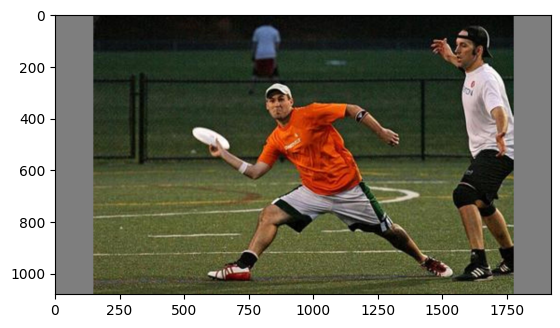

In [ ]:
#Visualizando imagem

img = cv2.imread(caminhos_teste[20])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


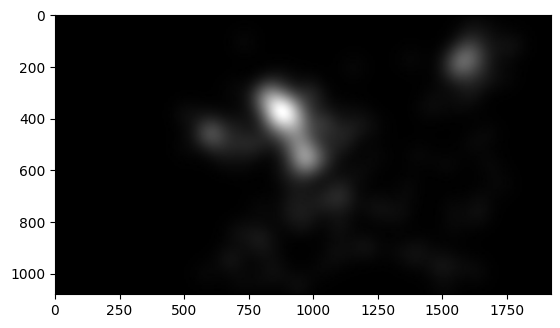

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Arquivos - Dados/Saliency Maps/trainSet/FIXATIONMAPS/Action/197.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


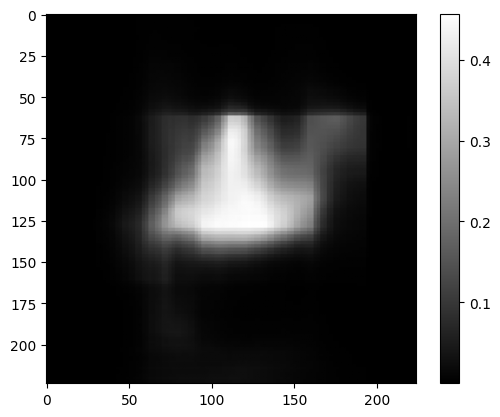

In [ ]:
#Visualizando predição

pred = pred.squeeze()
plt.imshow(pred, cmap='gray')
plt.colorbar()
plt.show()